In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import tqdm

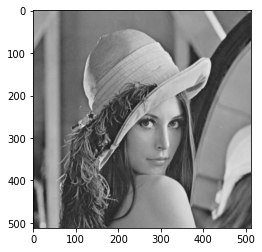

In [2]:
lena = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)
plt.imshow(lena, cmap='gray', vmin=0, vmax=255)

In [3]:
def add_noise_gaussian(lena, amp):
    after = np.copy(lena)
    for r in range(after.shape[0]):
        for c in range(after.shape[1]):
            noise = int(lena[r][c] + amp * random.gauss(0, 1))
            if (noise > 255): noise = 255
            if (noise < 0): noise = 0
            after[r][c] = noise
    return after

In [4]:
def add_salt_paper(lena, threshold):
    after = np.copy(lena)
    for r in range(after.shape[0]):
        for c in range(after.shape[1]):
            rn = random.uniform(0.0, 1.0)
            if (rn <= threshold):
                after[r][c] = 0
            elif (rn >= 1.0 - threshold):
                after[r][c] = 255
    return after

In [5]:
def filter(image, size, func):
    result = np.empty(image.shape)

    # padding
    margin = (size - 1) // 2
    image_pad = cv2.copyMakeBorder(image, margin, margin, margin, margin, cv2.BORDER_REFLECT)
    
    for r in range(margin, image_pad.shape[0] - margin):
        for c in range(margin, image_pad.shape[1] - margin):
            result[r - margin, c - margin] = int(func(image_pad[r - margin : r + margin + 1, c - margin : c + margin + 1]))

    return result

def filter_opening_then_closing(image, kernel):
    return cv2.morphologyEx(cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel), cv2.MORPH_CLOSE, kernel)

def filter_closing_then_opening(image, kernel):
    return cv2.morphologyEx(cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel), cv2.MORPH_OPEN, kernel)

def SNR(image, image_noise):
    image_normalized = image / 255
    image_noised_nomalized = image_noise / 255
    mu = np.average(image_normalized)
    VS = np.average((image_normalized - mu) ** 2)
    mu_N = np.average(image_noised_nomalized - image_normalized)
    VN = np.average((image_noised_nomalized - image_normalized - mu_N) ** 2)
    return 20 * np.log10(np.sqrt(VS) / np.sqrt(VN))

In [6]:
kernel = np.array([[0, 1, 1, 1, 0],
                    [1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1],
                    [0, 1, 1, 1, 0]]).astype(np.uint8)
images = {
    'ga-10': add_noise_gaussian(lena, 10),
    'ga-30': add_noise_gaussian(lena, 30),
    'sp-005': add_salt_paper(lena, 0.05),
    'sp-010': add_salt_paper(lena, 0.10),
}

with open('snr.txt', 'w') as file:
    for name, image in tqdm.tqdm(images.items()):
        box3 = filter(image, 3, np.average)    
        box5 = filter(image, 5, np.average)    
        med3 = filter(image, 3, np.median)
        med5 = filter(image, 5, np.median)
        oc = filter_opening_then_closing(image, kernel)
        co = filter_closing_then_opening(image, kernel)

        cv2.imwrite(name + ".png", image)
        cv2.imwrite(name + "-box3.png", box3)
        cv2.imwrite(name + "-box5.png", box5)
        cv2.imwrite(name + "-med3.png", med3)
        cv2.imwrite(name + "-med5.png", med5)
        cv2.imwrite(name + "-oc.png", oc)
        cv2.imwrite(name + "-co.png", co)

        print(name+" SNR = ", SNR(lena, image), file=file)
        print('+ Box    3x3           SNR = ', SNR(lena, box3), file=file)
        print('+ Box    5x5           SNR = ', SNR(lena, box5), file=file)
        print('+ Median 3x3           SNR = ', SNR(lena, med3), file=file)
        print('+ Median 5x5           SNR = ', SNR(lena, med5), file=file)
        print('+ Opening then Closing SNR = ', SNR(lena, oc), file=file)
        print('+ Closing then Opening SNR = ', SNR(lena, co), file=file)
        print("", file=file)

100%|██████████| 4/4 [00:58<00:00, 14.73s/it]
